In [ ]:
cd /content/drive/MyDrive/[Projects]/AI Hub/Pose Detection 기반 실시간 낙상 감지 시스템 개발/Data

/content/drive/MyDrive/[Projects]/AI Hub/Pose Detection 기반 실시간 낙상 감지 시스템 개발/Data


In [ ]:
import warnings

warnings.filterwarnings('ignore')

In [ ]:
import pandas as pd
import numpy as np

train_df = pd.read_csv('output_train_added.csv')
val_df = pd.read_csv('output_val_added.csv')

In [ ]:
train_df = train_df.interpolate().fillna(0)
val_df = val_df.interpolate().fillna(0)

## **Near Fall 생성 (A_T1)**

In [ ]:
W_METHOD_A = {
    'mean_joint_velocity': 0.3,
    'mean_angular_velocity': 0.4,
    'com_velocity': 0.3
}

In [ ]:
def compute_instability_method_A(df, weights):
    score = (
        weights['mean_joint_velocity']   * df['mean_joint_velocity'] +
        weights['mean_angular_velocity'] * df['mean_angular_velocity'] +
        weights['com_velocity']          * df['com_velocity']
    )
    return score

train_df['instability_A'] = compute_instability_method_A(train_df, W_METHOD_A)
val_df['instability_A'] = compute_instability_method_A(val_df, W_METHOD_A)

In [ ]:
def apply_threshold_global(df, score_col, percentile=95):
    th = np.percentile(df[score_col], percentile)

    near_fall = (
        (df['label'] == 0) &
        (df[score_col] >= th)
    ).astype(int)

    return near_fall, th

In [ ]:
train_df['near_fall_A_T1'], th_A_T1 = apply_threshold_global(
    train_df,
    score_col='instability_A',
    percentile=95
)

val_df['near_fall_A_T1'], th_A_T1 = apply_threshold_global(
    val_df,
    score_col='instability_A',
    percentile=95
)

## **Near Fall 라벨 재정의**

In [ ]:
train_df['label_orig'] = train_df['label']
val_df['label_orig'] = val_df['label']

In [ ]:
def redefine_label_3class(df, near_fall_col):
    """
    return: np.ndarray of {0,1,2}
    """
    new_label = np.zeros(len(df), dtype=int)

    # 1. Fall
    new_label[df['label'] == 1] = 2

    # 2. Near-Fall (only from Normal)
    new_label[
        (df['label'] == 0) &
        (df[near_fall_col] == 1)
    ] = 1

    return new_label

train_df['label_3class'] = redefine_label_3class(
    train_df,
    near_fall_col='near_fall_A_T1'
)

val_df['label_3class'] = redefine_label_3class(
    val_df,
    near_fall_col='near_fall_A_T1'
)

## **Add New Features**

In [ ]:
def normalize_skeleton(sk):
    """
    sk: (51,) = [x,y,c] * 17
    return: (51,)
    """
    sk = sk.reshape(17, 3)

    # 중심: hip
    cx, cy = sk[11,0], sk[11,1]
    sk[:,0] -= cx
    sk[:,1] -= cy

    # scale: shoulder distance
    scale = np.linalg.norm(sk[5,:2] - sk[6,:2]) + 1e-6
    sk[:,0] /= scale
    sk[:,1] /= scale

    return sk.reshape(-1)

In [ ]:
def compute_velocity(curr, prev):
    """
    curr, prev: (51,)
    return: (34,) = dx,dy * 17
    """
    curr = curr.reshape(17,3)
    prev = prev.reshape(17,3)

    v = curr[:,:2] - prev[:,:2]   # (17,2)
    return v.reshape(-1)

In [ ]:
POSE_COLS = [c for c in train_df.columns if (
    c.endswith('_x') or
    c.endswith('_y') or
    c.endswith('_score')
)]

def add_pose_velocity_features(df):
    df = df.copy()

    for file, group in df.groupby('file'):
        idxs = group.index
        prev = None

        for i, idx in enumerate(idxs):
            sk = group.loc[idx, POSE_COLS].values  # (51,)

            sk_norm = normalize_skeleton(sk)

            if prev is None:
                vel = np.zeros(34)
            else:
                vel = compute_velocity(sk_norm, prev)

            df.loc[idx, POSE_NORM_COLS] = sk_norm
            df.loc[idx, VEL_COLS] = vel

            prev = sk_norm

    return df

train_df = add_pose_velocity_features(train_df)
val_df   = add_pose_velocity_features(val_df)

In [ ]:
train_df.to_csv('output_train_near_fall.csv', index=False)
val_df.to_csv('output_val_near_fall.csv', index=False)

## **Build LSTM**

In [ ]:
import torch
import random

def fix_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [ ]:
def make_sequences_3class(df, window_size=30, step=1, label_col='label_3class'):
    x, y = [], []

    for file, group in df.groupby("file"):
        data   = group[FEATURE_COLS].values   # (T, 85)
        labels = group[label_col].values

        for i in range(0, len(data) - window_size + 1, step):
            seq = data[i:i+window_size]
            window_labels = labels[i:i+window_size]

            if 2 in window_labels:
                target = 2
            elif 1 in window_labels:
                target = 1
            else:
                target = 0

            x.append(seq)
            y.append(target)

    return np.array(x), np.array(y)

In [ ]:
import torch.nn as nn
class LSTMModel(nn.Module):
    def __init__(self, input_size=85, hidden_size=64, num_classes=3):
        super().__init__()
        self.lstm = nn.LSTM(input_size=input_size,
                            hidden_size=hidden_size,
                            batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        _, (h, _) = self.lstm(x)
        return self.fc(h[-1])   # (B, 3)

In [ ]:
from torch.utils.data import TensorDataset, DataLoader
from sklearn.utils.class_weight import compute_class_weight

def train_model_3class(x, y, x_val, y_val, epochs=10, batch_size=64, lr=1e-3):

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = LSTMModel(num_classes=3).to(device)

    class_weights = compute_class_weight(
        class_weight='balanced',
        classes=np.array([0,1,2]),
        y=y
    )
    loss_fn = nn.CrossEntropyLoss(
        weight=torch.tensor(class_weights, dtype=torch.float).to(device)
    )

    optim = torch.optim.Adam(model.parameters(), lr=lr)

    train_ds = TensorDataset(
        torch.tensor(x).float(),
        torch.tensor(y).long()
    )
    val_ds = TensorDataset(
        torch.tensor(x_val).float(),
        torch.tensor(y_val).long()
    )

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    val_loader   = DataLoader(val_ds, batch_size=batch_size, shuffle=False)

    for epoch in range(epochs):
        model.train()
        total_loss = 0

        for seq, label in train_loader:
            seq = seq.to(device)
            label = label.to(device)

            logits = model(seq)
            loss = loss_fn(logits, label)

            optim.zero_grad()
            loss.backward()
            optim.step()

            total_loss += loss.item()

        print(f"[Epoch {epoch+1}] loss={total_loss/len(train_loader):.4f}")

    return model

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_score, recall_score

def evaluate_3class(model, x_val, y_val):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()

    preds = []

    loader = DataLoader(
        TensorDataset(torch.tensor(x_val).float()),
        batch_size=64,
        shuffle=False
    )

    with torch.no_grad():
        for seq, in loader:
            seq = seq.to(device)
            logits = model(seq)
            pred = torch.argmax(logits, dim=1)
            preds.extend(pred.cpu().numpy())

    preds = np.array(preds)
    y_val = np.array(y_val)

    # 핵심 지표
    f1_macro = f1_score(y_val, preds, average="macro", zero_division=0)
    f1_weighted = f1_score(y_val, preds, average="weighted", zero_division=0)
    precision_macro = precision_score(y_val, preds, average="macro", zero_division=0)
    recall_macro = recall_score(y_val, preds, average="macro", zero_division=0)

    print(classification_report(
        y_val, preds,
        target_names=["Normal","Near-Fall","Fall"]
    ))
    print(confusion_matrix(y_val, preds))

    return {
        "F1_macro": f1_macro,
        "F1_weighted": f1_weighted,
        "Precision_macro": precision_macro,
        "Recall_macro": recall_macro
    }

In [ ]:
window_to_model = {}
results = []

POSE_NORM_COLS = [f'pose_norm_{i}' for i in range(51)]
VEL_COLS       = [f'vel_{i}' for i in range(34)]

FEATURE_COLS = POSE_NORM_COLS + VEL_COLS
len(FEATURE_COLS)  # 85

85

In [ ]:
WINDOW = 10
fix_seed(42)

x_train, y_train = make_sequences_3class(
    train_df,
    window_size=WINDOW,
    label_col='label_3class'
)

x_val, y_val = make_sequences_3class(
    val_df,
    window_size=WINDOW,
    label_col='label_3class'
)

model_3cls_10 = train_model_3class(
    x_train, y_train,
    x_val, y_val,
    epochs=10,
    batch_size=64,
    lr=1e-3
)

window_to_model[WINDOW] = model_3cls_10

metrics = evaluate_3class(model_3cls_10, x_val, y_val)

results.append({
    "Window": WINDOW,
    "Model": "LSTM_3Class",
    **metrics
})

[Epoch 1] loss=0.5721
[Epoch 2] loss=0.4641
[Epoch 3] loss=0.4251
[Epoch 4] loss=0.3964
[Epoch 5] loss=0.3751
[Epoch 6] loss=0.3568
[Epoch 7] loss=0.3409
[Epoch 8] loss=0.3285
[Epoch 9] loss=0.3184
[Epoch 10] loss=0.3065
              precision    recall  f1-score   support

      Normal       0.97      0.83      0.89     41765
   Near-Fall       0.47      0.80      0.59      6515
        Fall       0.59      0.74      0.66      5592

    accuracy                           0.81     53872
   macro avg       0.68      0.79      0.71     53872
weighted avg       0.87      0.81      0.83     53872

[[34489  4998  2278]
 [  741  5226   548]
 [  501   954  4137]]


In [ ]:
WINDOW = 20
fix_seed(42)

x_train, y_train = make_sequences_3class(
    train_df,
    window_size=WINDOW,
    label_col='label_3class'
)

x_val, y_val = make_sequences_3class(
    val_df,
    window_size=WINDOW,
    label_col='label_3class'
)

model_3cls_20 = train_model_3class(
    x_train, y_train,
    x_val, y_val,
    epochs=10,
    batch_size=64,
    lr=1e-3
)

window_to_model[WINDOW] = model_3cls_20

metrics = evaluate_3class(model_3cls_20, x_val, y_val)

results.append({
    "Window": WINDOW,
    "Model": "LSTM_3Class",
    **metrics
})

[Epoch 1] loss=0.5404
[Epoch 2] loss=0.4225
[Epoch 3] loss=0.3781
[Epoch 4] loss=0.3490
[Epoch 5] loss=0.3258
[Epoch 6] loss=0.3064
[Epoch 7] loss=0.2918
[Epoch 8] loss=0.2787
[Epoch 9] loss=0.2665
[Epoch 10] loss=0.2576
              precision    recall  f1-score   support

      Normal       0.94      0.83      0.88     31331
   Near-Fall       0.58      0.79      0.67      8237
        Fall       0.73      0.80      0.76      8384

    accuracy                           0.82     47952
   macro avg       0.75      0.80      0.77     47952
weighted avg       0.84      0.82      0.82     47952

[[25959  3667  1705]
 [ 1057  6471   709]
 [  633  1074  6677]]


In [ ]:
WINDOW = 30
fix_seed(42)

x_train, y_train = make_sequences_3class(
    train_df,
    window_size=WINDOW,
    label_col='label_3class'
)

x_val, y_val = make_sequences_3class(
    val_df,
    window_size=WINDOW,
    label_col='label_3class'
)

model_3cls_30 = train_model_3class(
    x_train, y_train,
    x_val, y_val,
    epochs=10,
    batch_size=64,
    lr=1e-3
)

window_to_model[WINDOW] = model_3cls_30

metrics = evaluate_3class(model_3cls_30, x_val, y_val)

results.append({
    "Window": WINDOW,
    "Model": "LSTM_3Class",
    **metrics
})

[Epoch 1] loss=0.5301
[Epoch 2] loss=0.4001
[Epoch 3] loss=0.3490
[Epoch 4] loss=0.3138
[Epoch 5] loss=0.2874
[Epoch 6] loss=0.2683
[Epoch 7] loss=0.2526
[Epoch 8] loss=0.2375
[Epoch 9] loss=0.2287
[Epoch 10] loss=0.2178
              precision    recall  f1-score   support

      Normal       0.91      0.79      0.85     22486
   Near-Fall       0.58      0.80      0.67      8450
        Fall       0.85      0.83      0.84     11096

    accuracy                           0.80     42032
   macro avg       0.78      0.81      0.79     42032
weighted avg       0.83      0.80      0.81     42032

[[17786  3609  1091]
 [ 1157  6736   557]
 [  536  1342  9218]]


In [ ]:
WINDOW = 40
fix_seed(42)

x_train, y_train = make_sequences_3class(
    train_df,
    window_size=WINDOW,
    label_col='label_3class'
)

x_val, y_val = make_sequences_3class(
    val_df,
    window_size=WINDOW,
    label_col='label_3class'
)

model_3cls_40 = train_model_3class(
    x_train, y_train,
    x_val, y_val,
    epochs=10,
    batch_size=64,
    lr=1e-3
)

window_to_model[WINDOW] = model_3cls_40

metrics = evaluate_3class(model_3cls_40, x_val, y_val)

results.append({
    "Window": WINDOW,
    "Model": "LSTM_3Class",
    **metrics
})

[Epoch 1] loss=0.5130
[Epoch 2] loss=0.3753
[Epoch 3] loss=0.3179
[Epoch 4] loss=0.2798
[Epoch 5] loss=0.2525
[Epoch 6] loss=0.2358
[Epoch 7] loss=0.2203
[Epoch 8] loss=0.2069
[Epoch 9] loss=0.1984
[Epoch 10] loss=0.1882
              precision    recall  f1-score   support

      Normal       0.86      0.74      0.80     14918
   Near-Fall       0.57      0.79      0.66      7738
        Fall       0.91      0.85      0.88     13456

    accuracy                           0.79     36112
   macro avg       0.78      0.79      0.78     36112
weighted avg       0.82      0.79      0.80     36112

[[11091  3219   608]
 [ 1116  6080   542]
 [  682  1383 11391]]


In [ ]:
WINDOW = 50
fix_seed(42)

x_train, y_train = make_sequences_3class(
    train_df,
    window_size=WINDOW,
    label_col='label_3class'
)

x_val, y_val = make_sequences_3class(
    val_df,
    window_size=WINDOW,
    label_col='label_3class'
)

model_3cls_50 = train_model_3class(
    x_train, y_train,
    x_val, y_val,
    epochs=10,
    batch_size=64,
    lr=1e-3
)

window_to_model[WINDOW] = model_3cls_50

metrics = evaluate_3class(model_3cls_50, x_val, y_val)

results.append({
    "Window": WINDOW,
    "Model": "LSTM_3Class",
    **metrics
})

[Epoch 1] loss=0.4554
[Epoch 2] loss=0.2897
[Epoch 3] loss=0.2269
[Epoch 4] loss=0.1840
[Epoch 5] loss=0.1543
[Epoch 6] loss=0.1383
[Epoch 7] loss=0.1227
[Epoch 8] loss=0.1149
[Epoch 9] loss=0.1079
[Epoch 10] loss=0.0996
              precision    recall  f1-score   support

      Normal       0.82      0.79      0.80      9838
   Near-Fall       0.65      0.74      0.69      6722
        Fall       0.95      0.91      0.93     13632

    accuracy                           0.83     30192
   macro avg       0.81      0.81      0.81     30192
weighted avg       0.84      0.83      0.84     30192

[[ 7758  1798   282]
 [ 1396  4997   329]
 [  297   913 12422]]


In [ ]:
result_df = pd.DataFrame(results)
result_df

,Window,Model,F1_macro,F1_weighted,Precision_macro,Recall_macro
0,10,LSTM_3Class,0.713282,0.829899,0.675635,0.789248
1,20,LSTM_3Class,0.769958,0.823065,0.750163,0.803513
2,30,LSTM_3Class,0.785375,0.809578,0.779262,0.806297
3,40,LSTM_3Class,0.778066,0.797532,0.779328,0.791911
4,50,LSTM_3Class,0.809563,0.836985,0.807424,0.814398


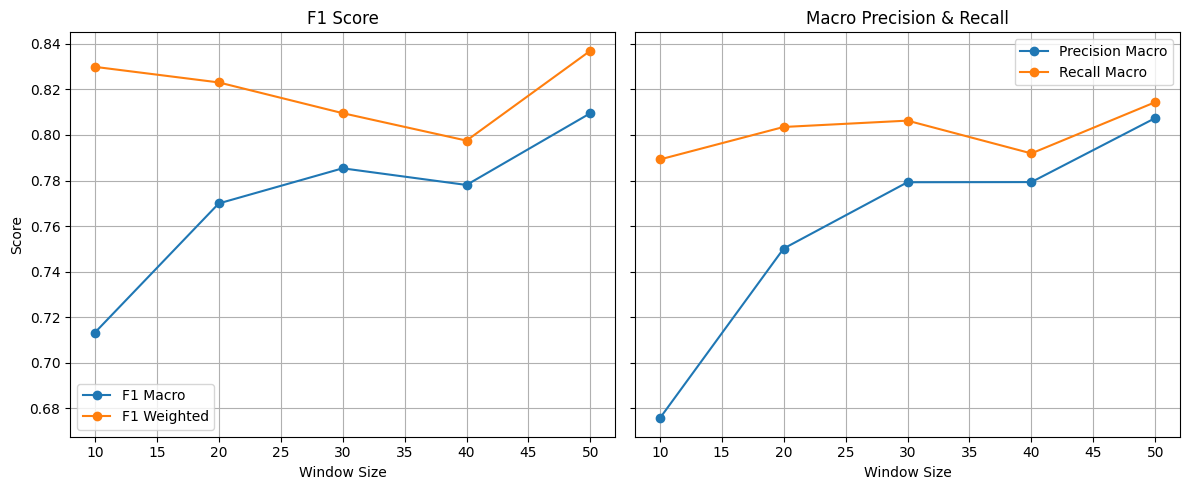

In [ ]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(12,5), sharey=True)

# (1) F1 비교
axes[0].plot(result_df['Window'], result_df['F1_macro'],
             marker='o', label='F1 Macro')
axes[0].plot(result_df['Window'], result_df['F1_weighted'],
             marker='o', label='F1 Weighted')
axes[0].set_title('F1 Score')
axes[0].set_xlabel('Window Size')
axes[0].set_ylabel('Score')
axes[0].legend()
axes[0].grid(True)

# (2) Precision / Recall (Macro)
axes[1].plot(result_df['Window'], result_df['Precision_macro'],
             marker='o', label='Precision Macro')
axes[1].plot(result_df['Window'], result_df['Recall_macro'],
             marker='o', label='Recall Macro')
axes[1].set_title('Macro Precision & Recall')
axes[1].set_xlabel('Window Size')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

## **Prediction**

In [ ]:
# !pip install ultralytics

In [ ]:
LABEL = {
    0: "Normal",
    1: "Warning",
    2: "Fall"
}

def make_feature(curr, prev):
    """
    curr, prev: (51,)
    return: (85,)
    """
    curr_n = normalize_skeleton(np.array(curr))   # (51,)
    prev_n = normalize_skeleton(np.array(prev))   # (51,)

    vel = compute_velocity(curr_n, prev_n)        # (34,)
    return np.concatenate([curr_n, vel])          # (85,)

In [ ]:
import cv2
from ultralytics import YOLO

# ======================================
# YOLO 모델 로드
# ======================================
model = YOLO("yolov8s-pose.pt")
model.to("cuda")
model.fuse()  # 최적화

# keypoint 이름
kp_names = [
    "nose","left_eye","right_eye","left_ear","right_ear",
    "left_shoulder","right_shoulder","left_elbow","right_elbow",
    "left_wrist","right_wrist","left_hip","right_hip",
    "left_knee","right_knee","left_ankle","right_ankle"
]

# ======================================
# Skeleton batch 추출 함수
# ======================================
def extract_skeleton(video_path, batch_size=64):
    cap = cv2.VideoCapture(video_path)
    frame_idx = 0
    batch = []
    frame_data = []

    prev = [0.0] * (len(kp_names) * 3)  # 이전 프레임 보정용

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        batch.append(frame)

        if len(batch) == batch_size:
            results = model(batch, verbose=False)
            for r in results:
                if r.keypoints is not None and len(r.keypoints.xy) > 0:
                    keypoints = r.keypoints.xy[0].cpu().numpy()
                    conf = r.keypoints.conf[0].cpu().numpy()
                    sk = []
                    for i in range(17):
                        x, y = keypoints[i]
                        c = conf[i]
                        sk += [float(x), float(y), float(c)]
                    prev = sk
                else:
                    sk = prev
                frame_data.append((frame_idx, sk))
                frame_idx += 1
            batch = []

    # 남은 프레임 처리
    if len(batch) > 0:
        results = model(batch, verbose=False)
        for r in results:
            if r.keypoints is not None and len(r.keypoints.xy) > 0:
                keypoints = r.keypoints.xy[0].cpu().numpy()
                conf = r.keypoints.conf[0].cpu().numpy()
                sk = []
                for i in range(17):
                    x, y = keypoints[i]
                    c = conf[i]
                    sk += [float(x), float(y), float(c)]
                prev = sk
            else:
                sk = prev
            frame_data.append((frame_idx, sk))
            frame_idx += 1

    cap.release()
    return frame_data  # [(frame_idx, [x1,y1,c1,...,x17,y17,c17]), ...]

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
YOLOv8s-pose summary (fused): 81 layers, 11,615,724 parameters, 0 gradients, 30.2 GFLOPs


In [ ]:
import cv2

skeleton_connections = [
    (0,1),(0,2),(1,3),(2,4),
    (0,5),(0,6),(5,7),(7,9),
    (6,8),(8,10),(5,6),(5,11),
    (6,12),(11,12),(11,13),(13,15),
    (12,14),(14,16)
]

def predict_video_lstm_3class(
    input_path,
    model,
    output_path,
    window_size=20
):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()

    # 1) skeleton 추출
    frames_skel = extract_skeleton(input_path)
    features = []

    prev = frames_skel[0][1]   # 첫 프레임 기준
    for _, sk in frames_skel:
        feat = make_feature(sk, prev)
        features.append(feat)
        prev = sk

    sk_data = np.array(features)   # (T, 85)

    num_frames = len(sk_data)
    preds = np.zeros((num_frames, 3))  # (T, num_classes)

    # 2) sliding window 예측
    for i in range(num_frames - window_size + 1):
        seq = torch.tensor(
            sk_data[i:i+window_size]
        ).float().unsqueeze(0).to(device)

        with torch.no_grad():
            logits = model(seq)          # (1, 3)
            prob = torch.softmax(logits, dim=1).cpu().numpy()[0]

        preds[i + window_size - 1] = prob

    # 3) 비디오 쓰기
    cap = cv2.VideoCapture(input_path)
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    fps = cap.get(cv2.CAP_PROP_FPS)
    width  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

    frame_idx = 0
    while True:
        ret, frame = cap.read()
        if not ret or frame_idx >= num_frames:
            break

        _, sk = frames_skel[frame_idx]
        sk = np.array(sk).reshape(-1, 3)

        # Skeleton draw
        for x, y, c in sk:
            cv2.circle(frame, (int(x), int(y)), 3, (0,255,0), -1)
        for i, j in skeleton_connections:
            x1, y1, _ = sk[i]
            x2, y2, _ = sk[j]
            cv2.line(frame, (int(x1), int(y1)), (int(x2), int(y2)), (0,255,0), 2)

        # 예측 결과
        prob = preds[frame_idx]
        cls  = prob.argmax()
        label = LABEL[cls]

        color = (0,255,0)
        if label == "Warning":
            color = (0,255,255)
        elif label == "Fall":
            color = (0,0,255)

        cv2.putText(
            frame,
            f"{label} | N:{prob[0]:.2f} W:{prob[1]:.2f} F:{prob[2]:.2f}",
            (30, 50),
            cv2.FONT_HERSHEY_SIMPLEX,
            0.9,
            color,
            2
        )

        out.write(frame)
        frame_idx += 1

    cap.release()
    out.release()
    print("✅ Done:", output_path)

In [ ]:
input_path = '/content/drive/MyDrive/[Projects]/AI Hub/Pose Detection 기반 실시간 낙상 감지 시스템 개발/Data/data/낙상사고 위험동작 영상-센서 쌍 데이터_병원,후면낙상/3.개방데이터/1.데이터/Validation/01.원천데이터/VS/영상'

video_path = [
    '/Y/SY/00001_H_A_SY_C1/00001_H_A_SY_C1.mp4',
    '/Y/SY/00026_H_A_SY_C1/00026_H_A_SY_C1.mp4',
    '/Y/SY/00029_H_A_SY_C1/00029_H_A_SY_C1.mp4',
    '/Y/SY/00053_H_A_SY_C1/00053_H_A_SY_C1.mp4',
    '/Y/SY/00076_H_A_SY_C1/00076_H_A_SY_C1.mp4',
    '/N/N/00005_H_A_N_C1/00005_H_A_N_C1.mp4',
    '/N/N/00023_H_A_N_C1/00023_H_A_N_C1.mp4',
    '/N/N/00095_H_A_N_C1/00095_H_A_N_C1.mp4',
    '/N/N/00110_H_A_N_C1/00110_H_A_N_C1.mp4',
    '/N/N/00204_H_D_N_C1/00204_H_D_N_C1.mp4',
]

In [ ]:
for path in video_path:
    print("🎥 Processing:", path)

    predict_video_lstm_3class(
        input_path + path,
        model_3cls_10,
        f"output_3cls_10_{path.split('/')[3]}.mp4",
        window_size=10
    )

🎥 Processing: /Y/SY/00001_H_A_SY_C1/00001_H_A_SY_C1.mp4
✅ Done: output_3cls_10_00001_H_A_SY_C1.mp4
🎥 Processing: /Y/SY/00026_H_A_SY_C1/00026_H_A_SY_C1.mp4
✅ Done: output_3cls_10_00026_H_A_SY_C1.mp4
🎥 Processing: /Y/SY/00029_H_A_SY_C1/00029_H_A_SY_C1.mp4
✅ Done: output_3cls_10_00029_H_A_SY_C1.mp4
🎥 Processing: /Y/SY/00053_H_A_SY_C1/00053_H_A_SY_C1.mp4
✅ Done: output_3cls_10_00053_H_A_SY_C1.mp4
🎥 Processing: /Y/SY/00076_H_A_SY_C1/00076_H_A_SY_C1.mp4
✅ Done: output_3cls_10_00076_H_A_SY_C1.mp4
🎥 Processing: /N/N/00005_H_A_N_C1/00005_H_A_N_C1.mp4
✅ Done: output_3cls_10_00005_H_A_N_C1.mp4
🎥 Processing: /N/N/00023_H_A_N_C1/00023_H_A_N_C1.mp4
✅ Done: output_3cls_10_00023_H_A_N_C1.mp4
🎥 Processing: /N/N/00095_H_A_N_C1/00095_H_A_N_C1.mp4
✅ Done: output_3cls_10_00095_H_A_N_C1.mp4
🎥 Processing: /N/N/00110_H_A_N_C1/00110_H_A_N_C1.mp4
✅ Done: output_3cls_10_00110_H_A_N_C1.mp4
🎥 Processing: /N/N/00204_H_D_N_C1/00204_H_D_N_C1.mp4
✅ Done: output_3cls_10_00204_H_D_N_C1.mp4


In [ ]:
for path in video_path:
    print("🎥 Processing:", path)

    predict_video_lstm_3class(
        input_path + path,
        model_3cls_20,
        f"output_3cls_20_{path.split('/')[3]}.mp4",
        window_size=20
    )

🎥 Processing: /Y/SY/00001_H_A_SY_C1/00001_H_A_SY_C1.mp4
✅ Done: output_3cls_20_00001_H_A_SY_C1.mp4
🎥 Processing: /Y/SY/00026_H_A_SY_C1/00026_H_A_SY_C1.mp4
✅ Done: output_3cls_20_00026_H_A_SY_C1.mp4
🎥 Processing: /Y/SY/00029_H_A_SY_C1/00029_H_A_SY_C1.mp4
✅ Done: output_3cls_20_00029_H_A_SY_C1.mp4
🎥 Processing: /Y/SY/00053_H_A_SY_C1/00053_H_A_SY_C1.mp4
✅ Done: output_3cls_20_00053_H_A_SY_C1.mp4
🎥 Processing: /Y/SY/00076_H_A_SY_C1/00076_H_A_SY_C1.mp4
✅ Done: output_3cls_20_00076_H_A_SY_C1.mp4
🎥 Processing: /N/N/00005_H_A_N_C1/00005_H_A_N_C1.mp4
✅ Done: output_3cls_20_00005_H_A_N_C1.mp4
🎥 Processing: /N/N/00023_H_A_N_C1/00023_H_A_N_C1.mp4
✅ Done: output_3cls_20_00023_H_A_N_C1.mp4
🎥 Processing: /N/N/00095_H_A_N_C1/00095_H_A_N_C1.mp4
✅ Done: output_3cls_20_00095_H_A_N_C1.mp4
🎥 Processing: /N/N/00110_H_A_N_C1/00110_H_A_N_C1.mp4
✅ Done: output_3cls_20_00110_H_A_N_C1.mp4
🎥 Processing: /N/N/00204_H_D_N_C1/00204_H_D_N_C1.mp4
✅ Done: output_3cls_20_00204_H_D_N_C1.mp4


In [ ]:
for path in video_path:
    print("🎥 Processing:", path)

    predict_video_lstm_3class(
        input_path + path,
        model_3cls_30,
        f"output_3cls_30_{path.split('/')[3]}.mp4",
        window_size=30
    )

🎥 Processing: /Y/SY/00001_H_A_SY_C1/00001_H_A_SY_C1.mp4
✅ Done: output_3cls_30_00001_H_A_SY_C1.mp4
🎥 Processing: /Y/SY/00026_H_A_SY_C1/00026_H_A_SY_C1.mp4
✅ Done: output_3cls_30_00026_H_A_SY_C1.mp4
🎥 Processing: /Y/SY/00029_H_A_SY_C1/00029_H_A_SY_C1.mp4
✅ Done: output_3cls_30_00029_H_A_SY_C1.mp4
🎥 Processing: /Y/SY/00053_H_A_SY_C1/00053_H_A_SY_C1.mp4
✅ Done: output_3cls_30_00053_H_A_SY_C1.mp4
🎥 Processing: /Y/SY/00076_H_A_SY_C1/00076_H_A_SY_C1.mp4
✅ Done: output_3cls_30_00076_H_A_SY_C1.mp4
🎥 Processing: /N/N/00005_H_A_N_C1/00005_H_A_N_C1.mp4
✅ Done: output_3cls_30_00005_H_A_N_C1.mp4
🎥 Processing: /N/N/00023_H_A_N_C1/00023_H_A_N_C1.mp4
✅ Done: output_3cls_30_00023_H_A_N_C1.mp4
🎥 Processing: /N/N/00095_H_A_N_C1/00095_H_A_N_C1.mp4
✅ Done: output_3cls_30_00095_H_A_N_C1.mp4
🎥 Processing: /N/N/00110_H_A_N_C1/00110_H_A_N_C1.mp4
✅ Done: output_3cls_30_00110_H_A_N_C1.mp4
🎥 Processing: /N/N/00204_H_D_N_C1/00204_H_D_N_C1.mp4
✅ Done: output_3cls_30_00204_H_D_N_C1.mp4


In [ ]:
for path in video_path:
    print("🎥 Processing:", path)

    predict_video_lstm_3class(
        input_path + path,
        model_3cls_40,
        f"output_3cls_40_{path.split('/')[3]}.mp4",
        window_size=40
    )

🎥 Processing: /Y/SY/00001_H_A_SY_C1/00001_H_A_SY_C1.mp4
✅ Done: output_3cls_40_00001_H_A_SY_C1.mp4
🎥 Processing: /Y/SY/00026_H_A_SY_C1/00026_H_A_SY_C1.mp4
✅ Done: output_3cls_40_00026_H_A_SY_C1.mp4
🎥 Processing: /Y/SY/00029_H_A_SY_C1/00029_H_A_SY_C1.mp4
✅ Done: output_3cls_40_00029_H_A_SY_C1.mp4
🎥 Processing: /Y/SY/00053_H_A_SY_C1/00053_H_A_SY_C1.mp4
✅ Done: output_3cls_40_00053_H_A_SY_C1.mp4
🎥 Processing: /Y/SY/00076_H_A_SY_C1/00076_H_A_SY_C1.mp4
✅ Done: output_3cls_40_00076_H_A_SY_C1.mp4
🎥 Processing: /N/N/00005_H_A_N_C1/00005_H_A_N_C1.mp4
✅ Done: output_3cls_40_00005_H_A_N_C1.mp4
🎥 Processing: /N/N/00023_H_A_N_C1/00023_H_A_N_C1.mp4
✅ Done: output_3cls_40_00023_H_A_N_C1.mp4
🎥 Processing: /N/N/00095_H_A_N_C1/00095_H_A_N_C1.mp4
✅ Done: output_3cls_40_00095_H_A_N_C1.mp4
🎥 Processing: /N/N/00110_H_A_N_C1/00110_H_A_N_C1.mp4
✅ Done: output_3cls_40_00110_H_A_N_C1.mp4
🎥 Processing: /N/N/00204_H_D_N_C1/00204_H_D_N_C1.mp4
✅ Done: output_3cls_40_00204_H_D_N_C1.mp4


In [ ]:
for path in video_path:
    print("🎥 Processing:", path)

    predict_video_lstm_3class(
        input_path + path,
        model_3cls_50,
        f"output_3cls_50_{path.split('/')[3]}.mp4",
        window_size=50
    )

🎥 Processing: /Y/SY/00001_H_A_SY_C1/00001_H_A_SY_C1.mp4
✅ Done: output_3cls_50_00001_H_A_SY_C1.mp4
🎥 Processing: /Y/SY/00026_H_A_SY_C1/00026_H_A_SY_C1.mp4
✅ Done: output_3cls_50_00026_H_A_SY_C1.mp4
🎥 Processing: /Y/SY/00029_H_A_SY_C1/00029_H_A_SY_C1.mp4
✅ Done: output_3cls_50_00029_H_A_SY_C1.mp4
🎥 Processing: /Y/SY/00053_H_A_SY_C1/00053_H_A_SY_C1.mp4
✅ Done: output_3cls_50_00053_H_A_SY_C1.mp4
🎥 Processing: /Y/SY/00076_H_A_SY_C1/00076_H_A_SY_C1.mp4
✅ Done: output_3cls_50_00076_H_A_SY_C1.mp4
🎥 Processing: /N/N/00005_H_A_N_C1/00005_H_A_N_C1.mp4
✅ Done: output_3cls_50_00005_H_A_N_C1.mp4
🎥 Processing: /N/N/00023_H_A_N_C1/00023_H_A_N_C1.mp4
✅ Done: output_3cls_50_00023_H_A_N_C1.mp4
🎥 Processing: /N/N/00095_H_A_N_C1/00095_H_A_N_C1.mp4
✅ Done: output_3cls_50_00095_H_A_N_C1.mp4
🎥 Processing: /N/N/00110_H_A_N_C1/00110_H_A_N_C1.mp4
✅ Done: output_3cls_50_00110_H_A_N_C1.mp4
🎥 Processing: /N/N/00204_H_D_N_C1/00204_H_D_N_C1.mp4
✅ Done: output_3cls_50_00204_H_D_N_C1.mp4


## **Evaluate**

In [ ]:
def evaluate_metrics_3class(
    window,
    y_val,
    preds,
    probs,        # (N, 3)
    fps=10,
    true_fall_frame=None
):
    # Fall 기준 이진화
    y_fall = (y_val == 2).astype(int)
    pred_fall = (preds == 2).astype(int)

    # confusion matrix
    cm = confusion_matrix(y_fall, pred_fall)
    tn, fp, fn, tp = cm.ravel()

    # scores (Fall 기준)
    precision = precision_score(y_fall, pred_fall, zero_division=0)
    recall    = recall_score(y_fall, pred_fall, zero_division=0)
    f1        = f1_score(y_fall, pred_fall, zero_division=0)

    # latency
    latency = window / fps

    # miss / false alarm
    miss_rate = fn / (tp + fn + 1e-8)
    false_alarm_rate = fp / (tn + fp + 1e-8)

    # cost (Fall miss >> FP)
    cost_score = fp * 1 + fn * 10

    # smoothness (Fall 확률)
    smoothness = np.var(probs[:, 2])

    # detection delay
    detection_delay = None
    if true_fall_frame is not None and np.any(pred_fall == 1):
        pred_fall_frame = np.argmax(pred_fall == 1)
        detection_delay = (pred_fall_frame - true_fall_frame) / fps

    return {
        "Window": window,
        "F1_Fall": f1,
        "Precision_Fall": precision,
        "Recall_Fall": recall,
        "Latency_sec": latency,
        "Miss_rate": miss_rate,
        "False_alarm_rate": false_alarm_rate,
        "Cost_score": cost_score,
        "Smoothness_Fall": smoothness,
        "Detection_delay_sec": detection_delay
    }

In [ ]:
def predict_proba_3class(model, x):
    model.eval()
    device = next(model.parameters()).device
    x = torch.tensor(x).float().to(device)

    with torch.no_grad():
        logits = model(x)
        probs = torch.softmax(logits, dim=1).cpu().numpy()

    preds = probs.argmax(axis=1)
    return preds, probs

In [ ]:
results = []

for window in [10, 20, 30, 40, 50]:

    model = window_to_model[window]

    preds, probs = predict_proba_3class(model, x_val)

    if np.any(y_val == 2):
        gt_fall_frame = np.argmax(y_val == 2)
    else:
        gt_fall_frame = None

    metrics = evaluate_metrics_3class(
        window=window,
        y_val=y_val,
        preds=preds,
        probs=probs,
        fps=10,
        true_fall_frame=gt_fall_frame
    )

    results.append(metrics)

result_df = pd.DataFrame(results)
result_df

,Window,F1_Fall,Precision_Fall,Recall_Fall,Latency_sec,Miss_rate,False_alarm_rate,Cost_score,Smoothness_Fall,Detection_delay_sec
0,10,0.750470,0.961168,0.615537,1.0,0.384463,0.020471,52749,0.158153,-0.3
1,20,0.889915,0.962859,0.827245,2.0,0.172755,0.026268,23985,0.207918,0.4
2,30,0.927829,0.975489,0.884610,3.0,0.115390,0.018297,16033,0.218238,0.4
3,40,0.925697,0.963130,0.891065,4.0,0.108935,0.028080,15315,0.216733,0.4
4,50,0.931708,0.953119,0.911238,5.0,0.088762,0.036896,12711,0.225636,0.4
